# Diamonds Clustering - KMeans, DBSCAN, KNN(PCA)

- Dataset kind - The dataset has 53,940 records of diamonds

- Main features:
 
 - carat (carat weight of the diamond)

 - cut (cut quality of the cut)

 - color (color diamond color)

 - clarity (clarity a measurement of how clear the diamond is)

 - x (length in mm)

 - y (width in mm)
 
 - z (depth in mm)

 - depth (total depth percentage = z / mean(x, y))

 - table (width of top of diamond relative to widest point)

# 1. Load Data

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error 
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load Data
diamonds = pd.read_csv('Diamonds Prices2022.csv')

In [3]:
#View the five rows
diamonds.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
#Add a new column to this dataset by calculating the size ((length x width x depth) of the diamond:
diamonds["size"] = diamonds["x"] * diamonds["y"] * diamonds["z"]

In [5]:
#Change the order of the columns
col_names = ['price','carat', 'size', 'depth', 'table', 'color', 'clarity', 'cut']
diamonds = diamonds[col_names]
diamonds.head()

,price,carat,size,depth,table,color,clarity,cut
0,326,0.23,38.202030,61.5,55.0,E,SI2,Ideal
1,326,0.21,34.505856,59.8,61.0,E,SI1,Premium
2,327,0.23,38.076885,56.9,65.0,E,VS1,Good
3,334,0.29,46.724580,62.4,58.0,I,VS2,Premium
4,335,0.31,51.917250,63.3,58.0,J,SI2,Good


In [6]:
#Encoding categorical features
encoder = LabelEncoder()

encoder.fit(diamonds['cut'])
diamonds['cut'] = encoder.transform(diamonds['cut'])

encoder.fit(diamonds['color'])
diamonds['color'] = encoder.transform(diamonds['color'])

encoder.fit(diamonds['clarity'])
diamonds['clarity'] = encoder.transform(diamonds['clarity'])

diamonds.head()

,price,carat,size,depth,table,color,clarity,cut
0,326,0.23,38.202030,61.5,55.0,1,3,2
1,326,0.21,34.505856,59.8,61.0,1,2,3
2,327,0.23,38.076885,56.9,65.0,1,4,1
3,334,0.29,46.724580,62.4,58.0,5,5,3
4,335,0.31,51.917250,63.3,58.0,6,3,1


# 2.Train/Test split

In [7]:
#Split dataset in train and test Data
df = diamonds.copy()

#"cut" is my predictor variable
X = df.drop('cut',axis=1)

#Label or target variable
y = df['cut']

#Define the split in Training/Test and their proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

print(X_train.shape, y_train.shape)

(43154, 7) (43154,)


# 3.Data exploration 

In [8]:
#View summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53943 non-null  int64  
 1   carat    53943 non-null  float64
 2   size     53943 non-null  float64
 3   depth    53943 non-null  float64
 4   table    53943 non-null  float64
 5   color    53943 non-null  int64  
 6   clarity  53943 non-null  int64  
 7   cut      53943 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 3.3 MB


In [9]:
#Check number of features
df.columns

Index(['price', 'carat', 'size', 'depth', 'table', 'color', 'clarity', 'cut'], dtype='object')

In [10]:
#Check shape of the dataset
df.shape

(53943, 8)

In [11]:
#Check data types
df.dtypes

price        int64
carat      float64
size       float64
depth      float64
table      float64
color        int64
clarity      int64
cut          int64
dtype: object

In [12]:
#Check missing value
df.isnull().sum()

price      0
carat      0
size       0
depth      0
table      0
color      0
clarity    0
cut        0
dtype: int64

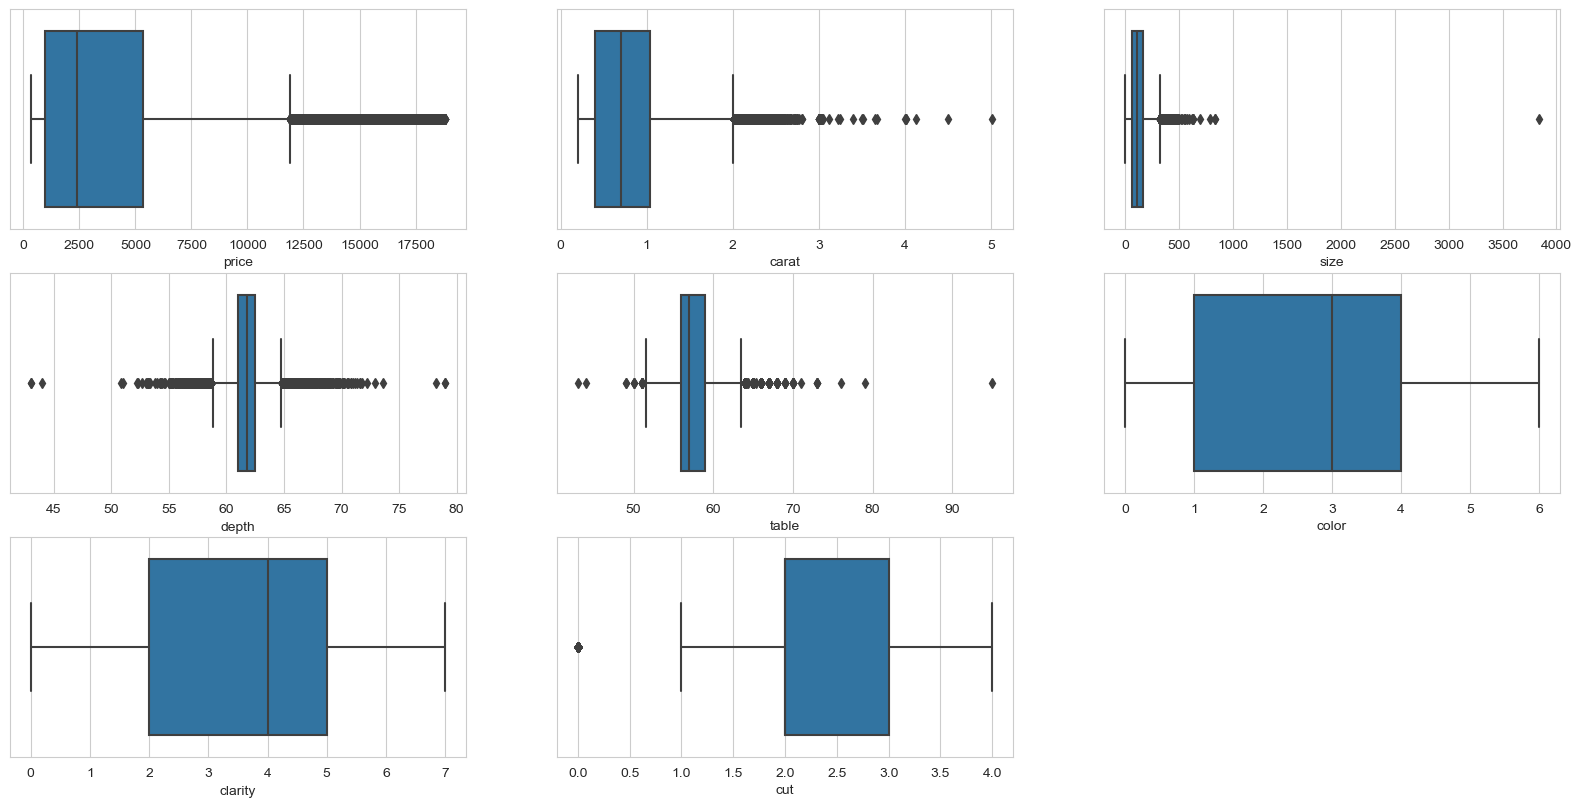

In [13]:
#Use boxplot to show numeric features 
fig = plt.figure(figsize=(20,20))
for col in range(len(df.columns)) :
    fig.add_subplot(6,3,col+1)
    sns.boxplot(x=df.iloc[ : , col])
plt.show()

We did a Boxplot of the data to see if there were outliers and we found a large number of outliers in the features(price, carat, size, depth, table).

In [14]:
#View the statistical summary of numercial variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,53943.0,3932.734294,3989.338447,326.0,950.00000,2401.000000,5324.000000,18823.00000
carat,53943.0,0.797935,0.473999,0.2,0.40000,0.700000,1.040000,5.01000
size,53943.0,129.848539,78.243172,0.0,65.13683,114.808572,170.841804,3840.59806
depth,53943.0,61.749322,1.432626,43.0,61.00000,61.800000,62.500000,79.00000
table,53943.0,57.457251,2.234549,43.0,56.00000,57.000000,59.000000,95.00000
color,53943.0,2.594127,1.701087,0.0,1.00000,3.000000,4.000000,6.00000
clarity,53943.0,3.835104,1.724587,0.0,2.00000,4.000000,5.000000,7.00000
cut,53943.0,2.553047,1.027702,0.0,2.00000,2.000000,3.000000,4.00000


In [15]:
#Check correlation between different features
df.corr()

,price,carat,size,depth,table,color,clarity,cut
price,1.000000,0.921591,0.902385,-0.010630,0.127118,0.172520,-0.071525,0.039847
carat,0.921591,1.000000,0.976308,0.028234,0.181602,0.291439,-0.214280,0.017115
size,0.902385,0.976308,1.000000,0.009169,0.167384,0.284270,-0.206621,0.021431
depth,-0.010630,0.028234,0.009169,1.000000,-0.295798,0.047316,-0.053044,-0.194279
table,0.127118,0.181602,0.167384,-0.295798,1.000000,0.026457,-0.088225,0.150341
color,0.172520,0.291439,0.284270,0.047316,0.026457,1.000000,-0.027781,0.000269
clarity,-0.071525,-0.214280,-0.206621,-0.053044,-0.088225,-0.027781,1.000000,0.028235
cut,0.039847,0.017115,0.021431,-0.194279,0.150341,0.000269,0.028235,1.000000


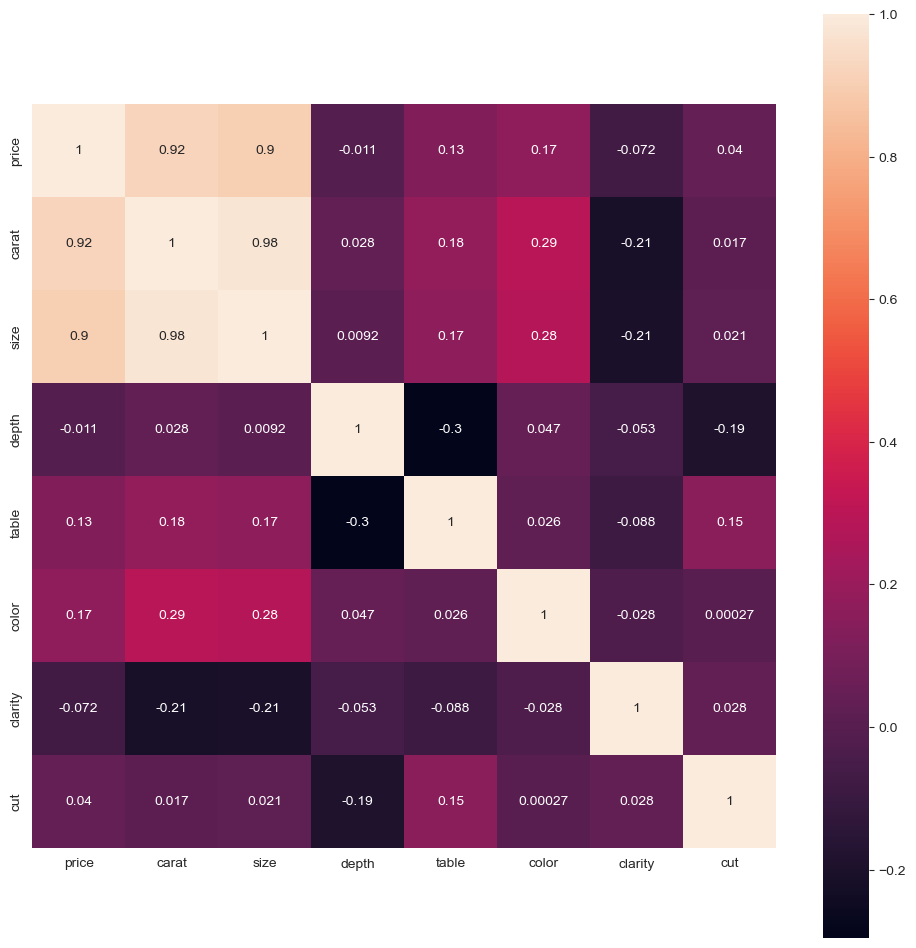

In [16]:
#Use heatmap to show correlation between features
plt.figure(figsize = (12,12))
sns.heatmap(data = df.corr(), square = True, annot = True);

Findings:

- Price with Carat have a strong positive relation

- Price with Size have also a strong positive relation

- Price with Clarity have a negative relation

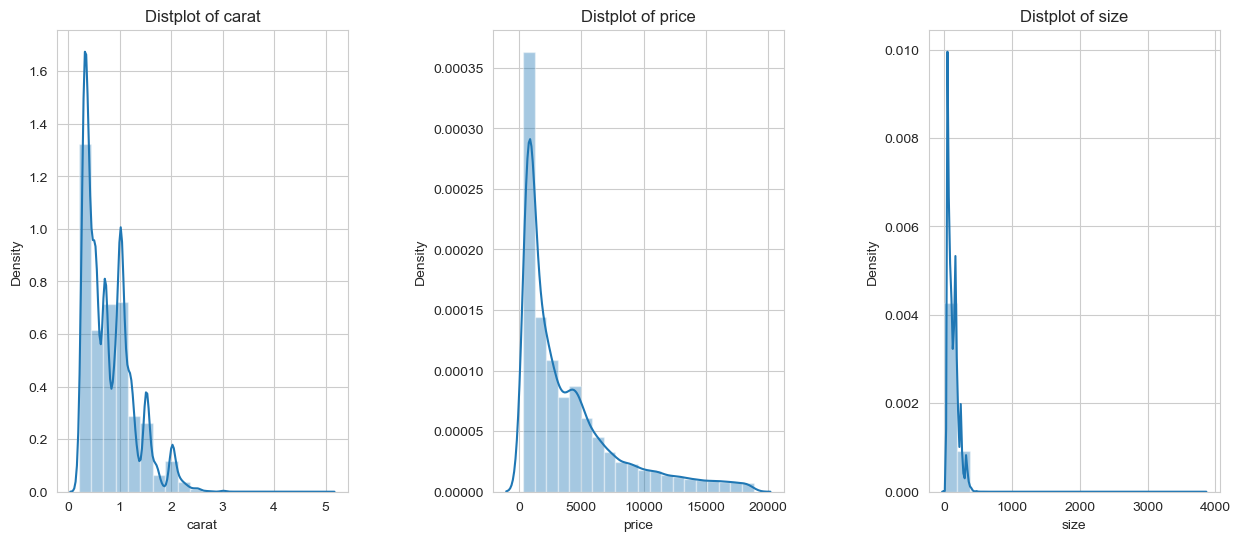

In [17]:
#Use seaborn displot to show distrubtion for different features ('Carat', 'Price', 'Size')
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['carat' , 'price' , 'size']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

Findings: These three density curve are all right skewed, then the mean value is greater than the median value.

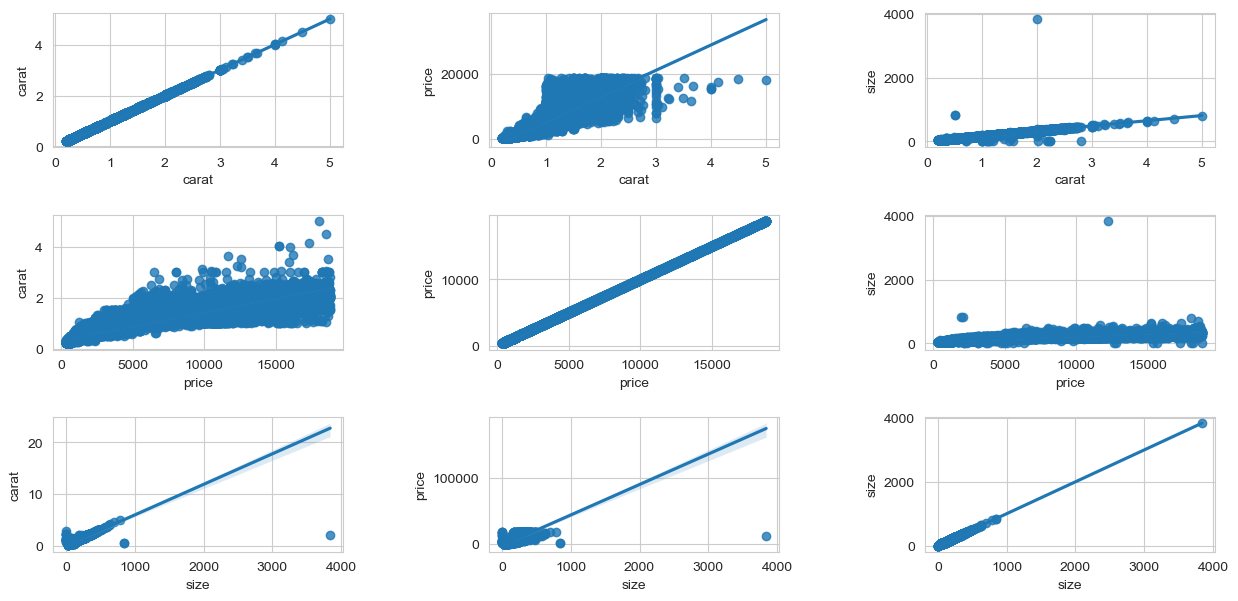

In [18]:
#Plot to see relationship between the features 'carat', 'price', 'size'
plt.figure(1 , figsize = (15 , 7))
n = 0 
for x in ['carat' , 'price' , 'size']:
    for y in ['carat' , 'price' , 'size']:
        n += 1
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()

# 4.Prepare the data

# Now Scaling the DataFrame

In [19]:
#Normalize the data and avoid the problem that generates outliers
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df)

Many outliers were found so they could not be eliminated since the amount of data would be significantly reduced, so it was decided to normalize the data and avoid the problem that generates outliers.

In [20]:
df1 = pd.DataFrame(X_scaled) 

In [21]:
df1

,0,1,2,3,4,5,6,7
0,0.000000,0.006237,0.009947,0.513889,0.230769,0.166667,0.428571,0.50
1,0.000000,0.002079,0.008985,0.466667,0.346154,0.166667,0.285714,0.75
2,0.000054,0.006237,0.009914,0.386111,0.423077,0.166667,0.571429,0.25
3,0.000433,0.018711,0.012166,0.538889,0.288462,0.833333,0.714286,0.75
4,0.000487,0.022869,0.013518,0.563889,0.288462,1.000000,0.428571,0.25
...,...,...,...,...,...,...,...,...
53938,0.131427,0.137214,0.036652,0.500000,0.288462,0.666667,0.428571,0.75
53939,0.131427,0.114345,0.032435,0.533333,0.230769,0.000000,0.428571,0.50
53940,0.131373,0.106029,0.030201,0.486111,0.230769,0.166667,0.285714,0.75
53941,0.131373,0.106029,0.029374,0.466667,0.365385,0.333333,0.285714,0.75


In [22]:
df1.columns

RangeIndex(start=0, stop=8, step=1)

In [23]:
df1.columns =['price', 'carat', 'size', 'depth', 'table', 'color', 'clarity', 'cut']

In [24]:
#Descriptive Statistics
df1.describe()

,price,carat,size,depth,table,color,clarity,cut
count,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000
mean,0.194990,0.124311,0.033809,0.520815,0.278024,0.432355,0.547872,0.638262
std,0.215675,0.098544,0.020373,0.039795,0.042972,0.283515,0.246370,0.256925
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.033735,0.041580,0.016960,0.500000,0.250000,0.166667,0.285714,0.500000
50%,0.112180,0.103950,0.029893,0.522222,0.269231,0.500000,0.571429,0.500000
75%,0.270206,0.174636,0.044483,0.541667,0.307692,0.666667,0.714286,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


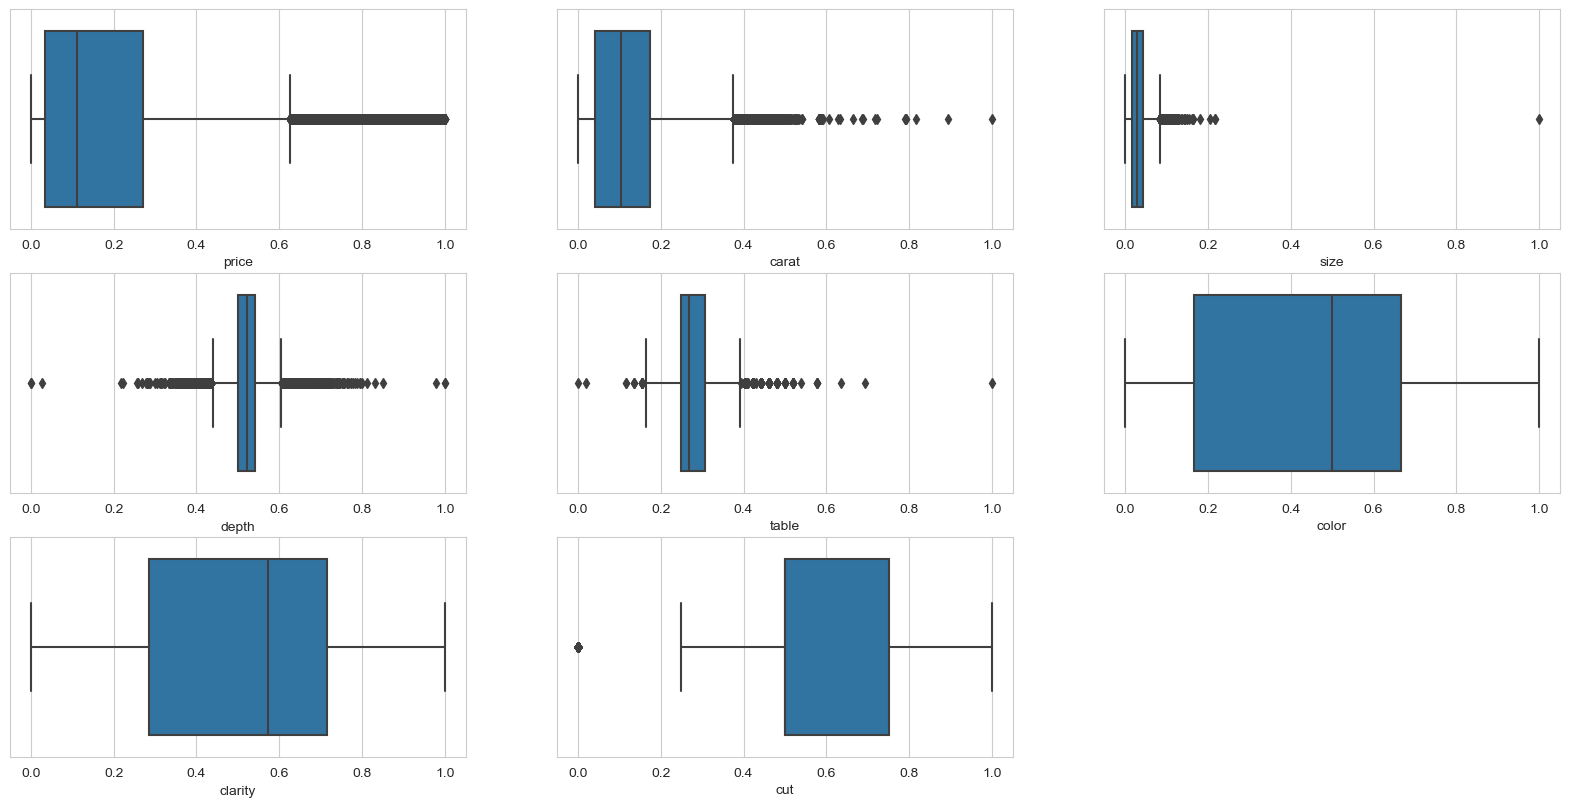

In [25]:
#Use boxplot to check numeric features again
fig = plt.figure(figsize=(20,20))
for col in range(len(df1.columns)) :
    fig.add_subplot(6,3,col+1)
    sns.boxplot(x=df1.iloc[ : , col])
plt.show()

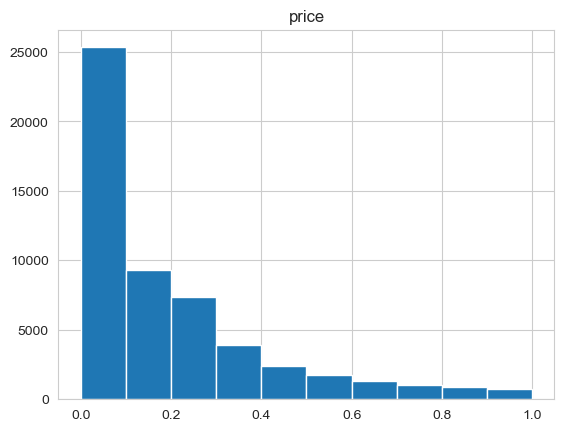

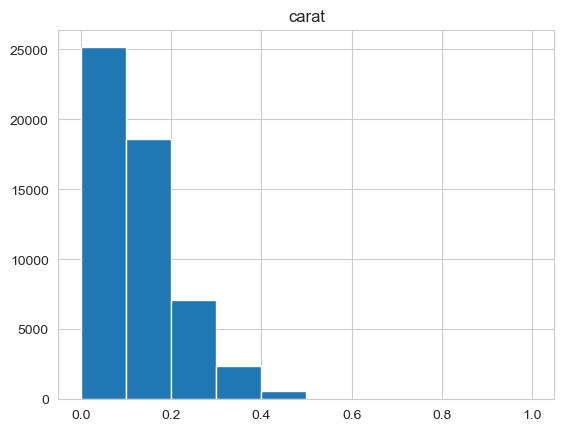

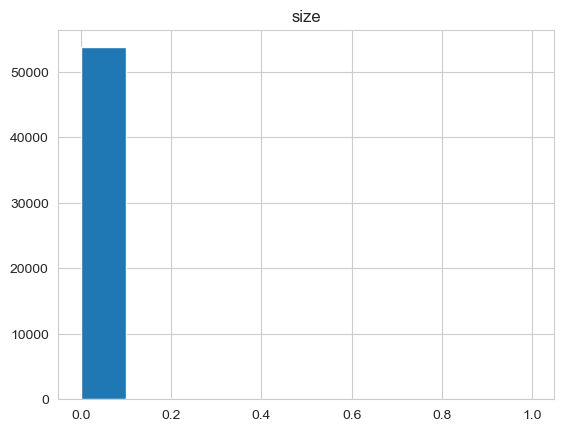

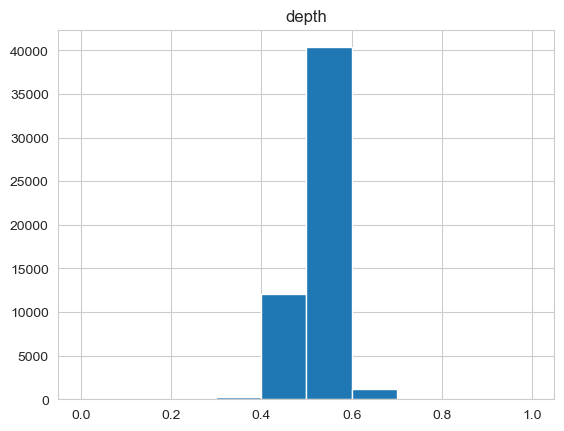

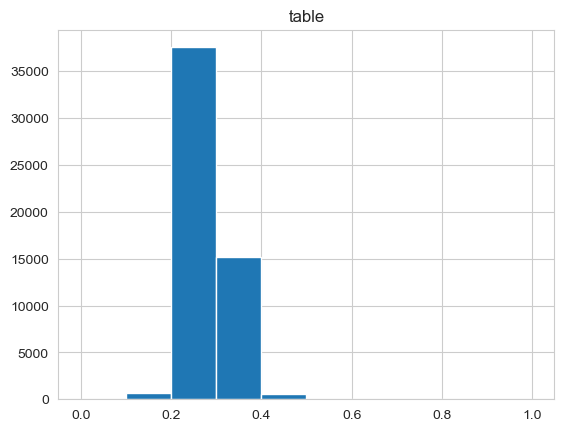

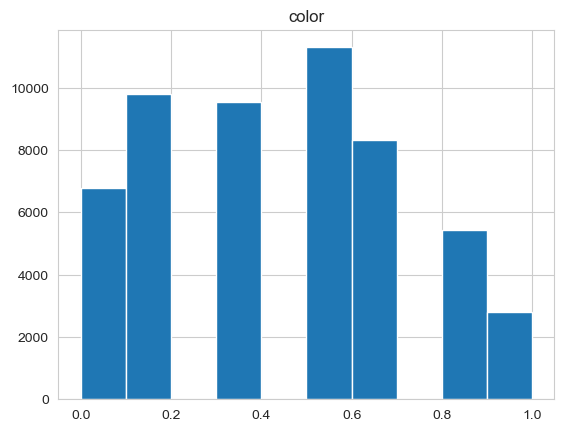

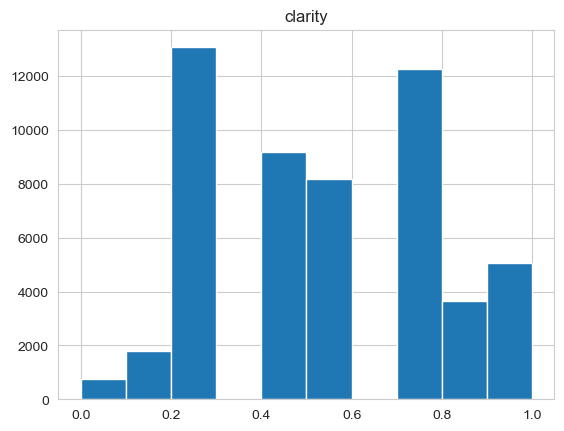

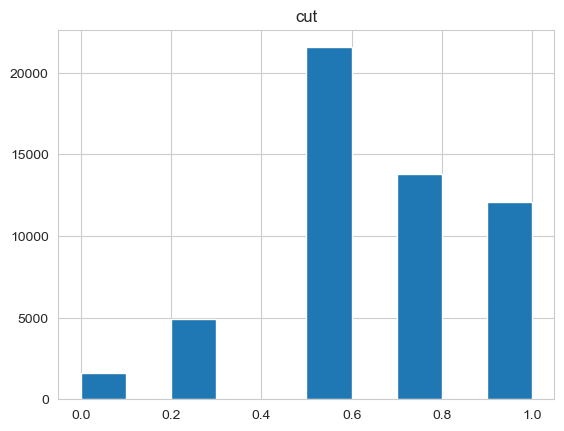

In [26]:
#Use histogram to show the different features 
for col in df1:
    df1[[col]].hist()

# 5.Principal Component Analysis (PCA)

# Dimensionality reduction

In [27]:
# Create an instance of PCA
pca = PCA(n_components = 2) #Define n_components=2

pca.fit(df1)
df2 = pca.transform(df1)

In [28]:
df2.shape

(53943, 2)

We use PCA to reduce the dimensionality of the data so we could be able to graph the clusters correctly

# 6.K-means clustering

K-Means is a clustering algorithm who's main goal is to group similar elements or data points into a cluster

" K " in K-Means Clustering represent the number of cluster.

Algorithm:

1) Specify the number k of clusters to assign.

2) Randomly initialize k centroids.

3) Repeat

4) Expectation: Assign each point to its closet centroid.

5) Maximization: Compute the new centroid(mean) of each cluster.

6) Until The centroid positions do not change.

K-means pros:

- It is simple, highly flexible, and efficient. The simplicity of k-means makes it easy to explain the results in contrast to Neural Networks.

- The flexibility of k-means allows for easy adjustment if there are problems.

- The efficiency of k-means implies that the algorithm is good at segmenting a dataset.

- An instance can change cluster (move to another cluster) when the centroids are recomputed

- Easy to interpret the clustering results.

cons:

- No-optimal set of clusters: K-means doesn’t allow the development of an optimal set of clusters and for effective results, you should decide on the clusters before.

- Lacks consistency: K-means clustering gives varying results on different runs of an algorithm. A random choice of cluster patterns yields different clustering results resulting in inconsistency.

- Uniform effect: It produces clusters with uniform sizes even when the input data has different sizes.

- Order of values: The way in which data is ordered in building the algorithm affects the final results of the data set.

- Sensitivity to scale: Changing or rescaling the dataset either through normalization or standardization will completely change the final results.

# Hyperparameter tunning

We’ll look at The Elbow method that are commonly used to evaluate the appropriate number of clusters:


In [29]:
! pip install yellowbrick

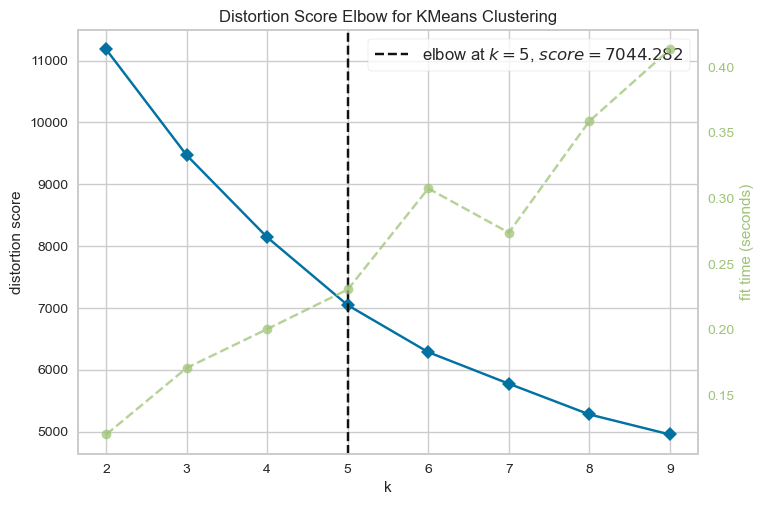

In [30]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(df1)
visualizer.show()
plt.show()

From the graph, I select : k : Clusters = 5

In [31]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df1)
    sse.append(kmeans.inertia_)

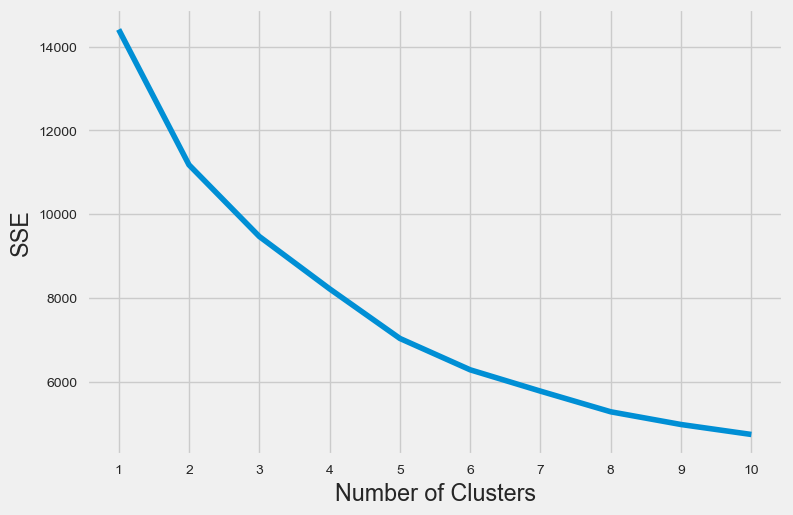

In [32]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [33]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

5

From the graph, I select : k : Clusters = 5

# KMeans

In [34]:
#Model building using KMeans
kmeans =  KMeans(n_clusters=5, max_iter=600, algorithm = 'auto')
kmeans.fit(df1)

KMeans(max_iter=600, n_clusters=5)

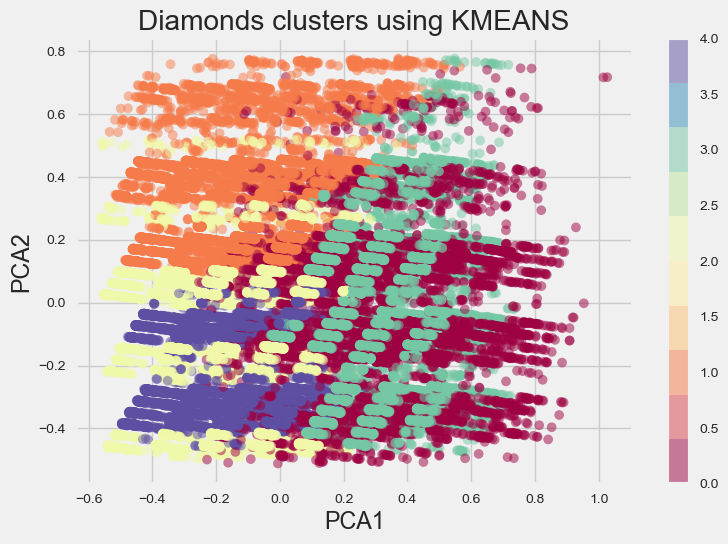

In [35]:
#Use scatterplot to show clusters via PCA
plt.scatter(df2[:, 0], df2[:, 1],
            c= kmeans.labels_.astype(float), edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Diamonds clusters using KMEANS') 
plt.colorbar();

In [36]:
df1["cluster"] = kmeans.labels_.astype(float)

In [37]:
df1

,price,carat,size,depth,table,color,clarity,cut,cluster
0,0.000000,0.006237,0.009947,0.513889,0.230769,0.166667,0.428571,0.50,1.0
1,0.000000,0.002079,0.008985,0.466667,0.346154,0.166667,0.285714,0.75,4.0
2,0.000054,0.006237,0.009914,0.386111,0.423077,0.166667,0.571429,0.25,1.0
3,0.000433,0.018711,0.012166,0.538889,0.288462,0.833333,0.714286,0.75,3.0
4,0.000487,0.022869,0.013518,0.563889,0.288462,1.000000,0.428571,0.25,3.0
...,...,...,...,...,...,...,...,...,...
53938,0.131427,0.137214,0.036652,0.500000,0.288462,0.666667,0.428571,0.75,3.0
53939,0.131427,0.114345,0.032435,0.533333,0.230769,0.000000,0.428571,0.50,1.0
53940,0.131373,0.106029,0.030201,0.486111,0.230769,0.166667,0.285714,0.75,4.0
53941,0.131373,0.106029,0.029374,0.466667,0.365385,0.333333,0.285714,0.75,4.0


In [38]:
# Number of clusters in labels, ignoring noise if present.
labels_kmeans = kmeans.labels_
n_clusters_ = len(set(labels_kmeans)) - (1 if -1 in labels_kmeans else 0)
n_noise_ = list(labels_kmeans).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 0


We put in the dataset which cluster each diamond was going to belong to, so that the data can be analyzed dividing them into clusters and then we can see the characteristics of each group

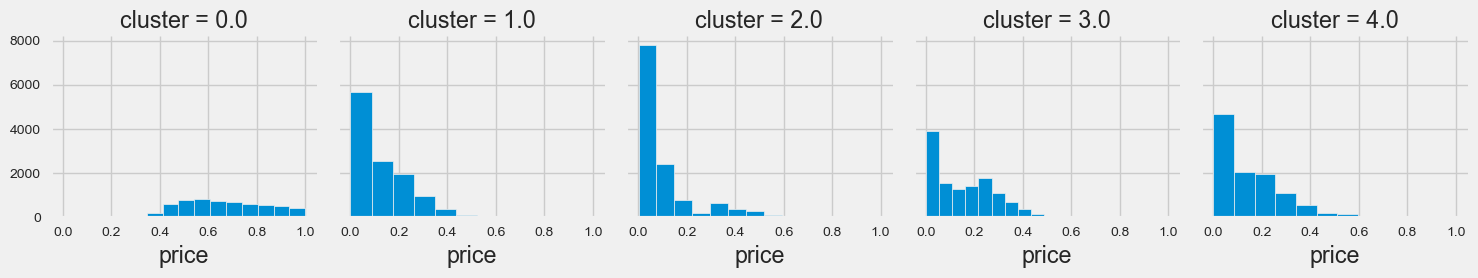

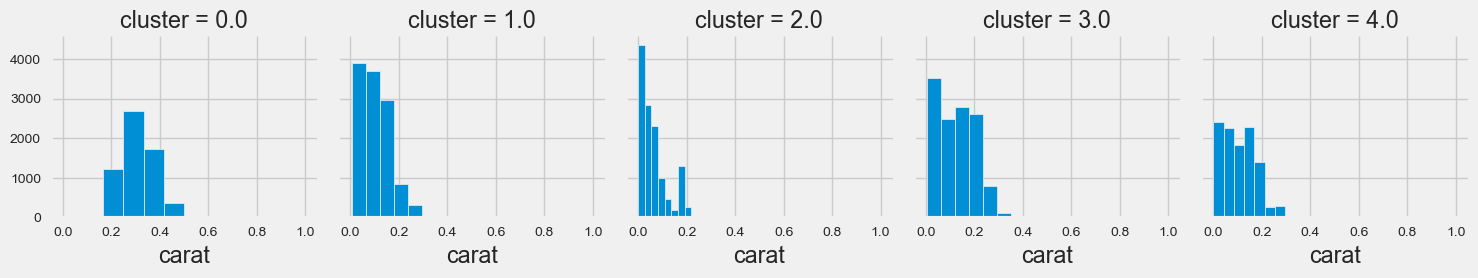

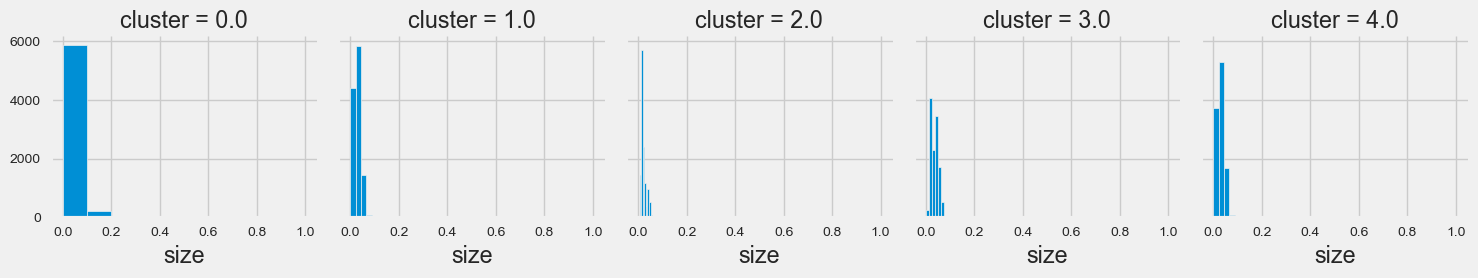

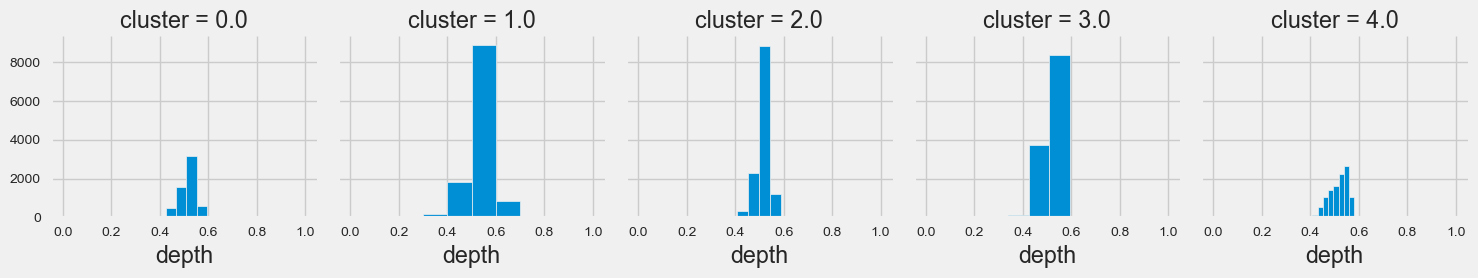

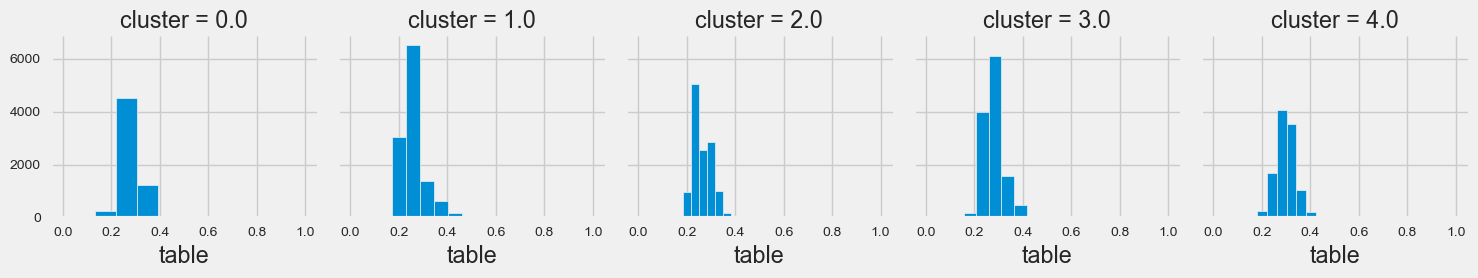

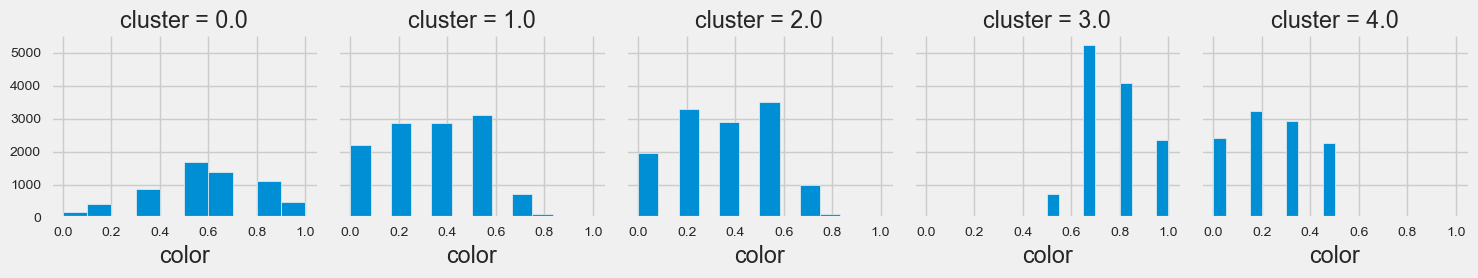

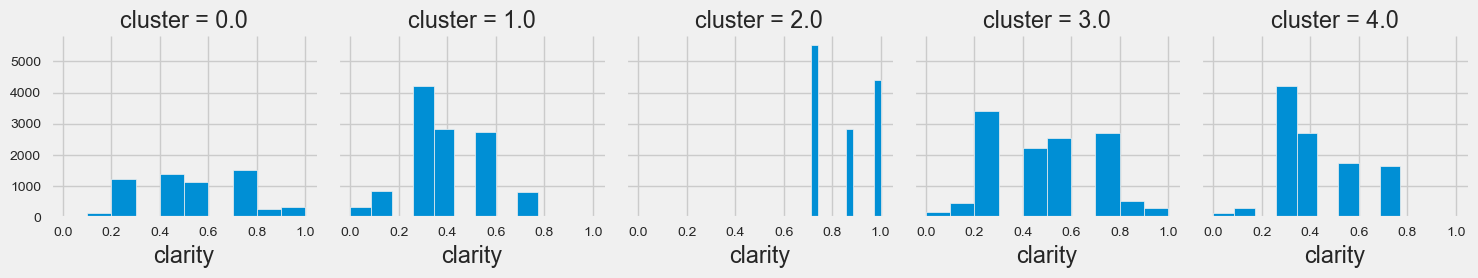

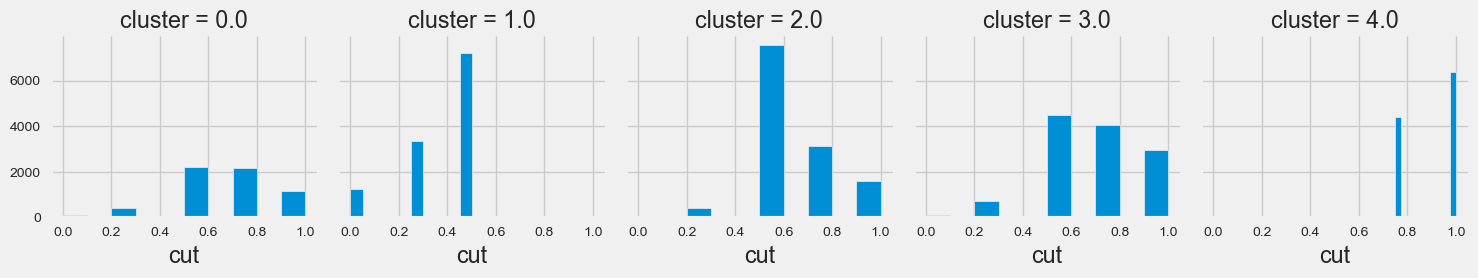

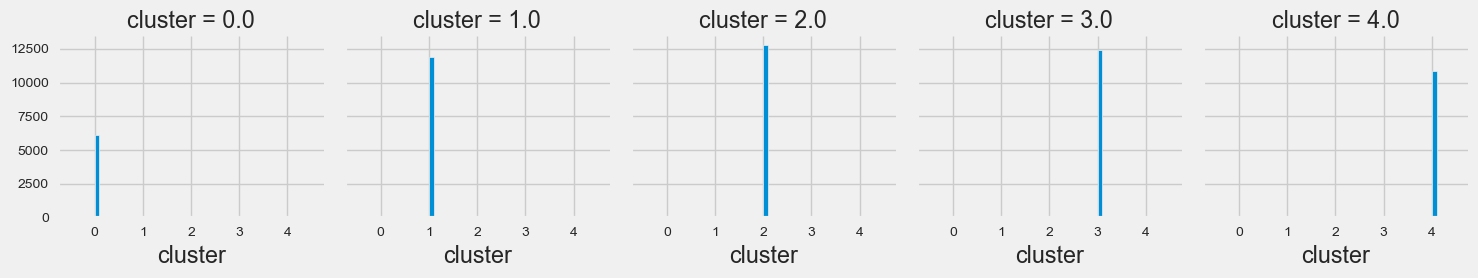

In [39]:
for c in df1:
    grid= sns.FacetGrid(df1, col='cluster')
    grid.map(plt.hist, c) 

# Validate with test data

In [40]:
kmeans=KMeans(5)
kmeans.fit_predict(df1)

array([4, 3, 4, ..., 3, 3, 3], dtype=int32)

In [41]:
y_pred = kmeans.predict(df1)

In [42]:
#preds = kmeans.labels_
data = pd.DataFrame(df)
data['cluster'] = y_pred
data.head(10)

,price,carat,size,depth,table,color,clarity,cut,cluster
0,326,0.23,38.202030,61.5,55.0,1,3,2,4
1,326,0.21,34.505856,59.8,61.0,1,2,3,3
2,327,0.23,38.076885,56.9,65.0,1,4,1,4
3,334,0.29,46.724580,62.4,58.0,5,5,3,0
4,335,0.31,51.917250,63.3,58.0,6,3,1,0
5,336,0.24,38.693952,62.8,57.0,6,7,4,0
6,336,0.24,38.830870,62.3,57.0,5,6,4,0
7,337,0.26,42.321081,61.9,55.0,4,2,4,0
8,337,0.22,36.425214,65.1,61.0,1,5,0,4
9,338,0.23,38.718000,59.4,61.0,4,4,4,0


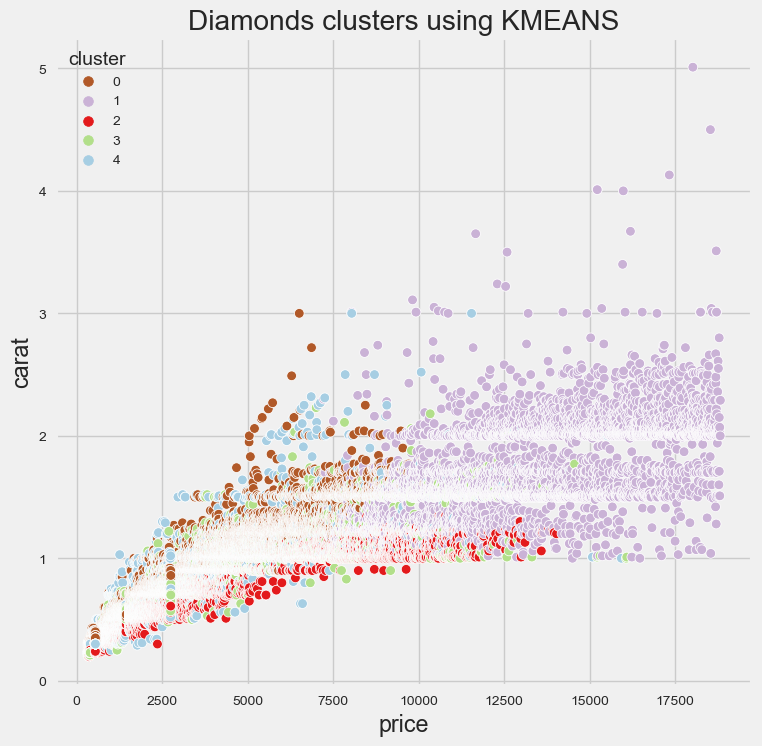

In [43]:
#Use scatterplot to show clusters via KMEANS
plt.figure(figsize=(8,8))
sns.scatterplot(x='price',y='carat',hue="cluster",data=data,palette='Paired_r')
plt.title('Diamonds clusters using KMEANS')
plt.show()

# 7. DBSCAN clustering

DBScan Clustering is a density-based clustering algorithm. The key fact of this algorithm is that the neighbourhood of each point in a cluster which is within a given radius (R) must have a minimum number of points (M). This algorithm has proved extremely efficient in detecting outliers and handling noise.

Algorithm:

The type of each point is determined. Each data point in our dataset may be either of the following:

1) Core Point: A data point is a core point if, there are at least M points in its neighborhood ie, within the specified radius (R).

2) Border Point: A data point is classified as a BORDER point if:

Its neighborhood contains less than M data points, or

It is reachable from some core point ie, it is within R-distance from a core point.

3) Outlier Point: An outlier is a point that is not a core point, and also, is not close enough to be reachable from a core point.

4) The outlier points are eliminated.

5) Core points that are neighbors are connected and put in the same cluster.

6) The border points are assigned to each cluster.

DBScan pros:

- DBSCAN can discover clusters of arbitrary shape, unlike k-means.

- It is robust to noise, as it can identify points that do not belong to any cluster as outliers.

- It does not require the number of clusters to be specified in advance.

cons:
 
- It is sensitive to the choice of the Eps and MinPts parameters.

- It does not work well with clusters of varying densities.

- It has a high computational cost when the number of data points is large.

- It is not guaranteed to find all clusters in the data.

# Hyperparameter tunning

In DBSCAN there are two major hyperparameters:

- eps

- min_samples

In [44]:
for eps in [i/10 for i in range(2,5)]:
    for min_samples in range (7,9):
        print(f'\neps {eps}')
        print(f'\min samples {min_samples}')
        
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        labels = dbscan.fit_predict(df1)
        score = silhouette_score(df1, labels)
        
        print(f'clusters present: {np.unique(labels)}')
        print(f'clusters sizes: {np.bincount(labels + 1)}')
        print(f'Silhouette Score: {score}')


eps 0.2
\min samples 7
clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23]
clusters sizes: [ 160 7237 4437 3338 4065  723 2946 1254 4512 6389 1591 3124 7574  420
  107   55   18 2144 2214   13  397 1136   76    5    8]
Silhouette Score: 0.18248017500506225

eps 0.2
\min samples 8
clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
clusters sizes: [ 192 7237 4437 3338 4065  720 2946 1249 4512 6389 1591 3124 7574  420
  107   46   18 2143 2214   13  395 1134   70    9]
Silhouette Score: 0.18264314964424133

eps 0.3
\min samples 7
clusters present: [-1  0  1  2  3  4]
clusters sizes: [   22 11853 10830 12380 12776  6082]
Silhouette Score: 0.6104377679436195

eps 0.3
\min samples 8
clusters present: [-1  0  1  2  3  4]
clusters sizes: [   23 11853 10830 12380 12776  6081]
Silhouette Score: 0.609979828840792

eps 0.4
\min samples 7
clusters present: [-1  0  1  2  3  4]
clusters sizes: [   10 11856 10830 123

Get the parameters for best silhouette score

The best hyperparameter are eps: 0.4 and min samples: 7 because it has the highest silhouette score, but samples is inlcuded with noise.

In [45]:
#Model building using DBScan
db = DBSCAN(eps=0.4, min_samples=7).fit(df1)
db_labels = db.labels_

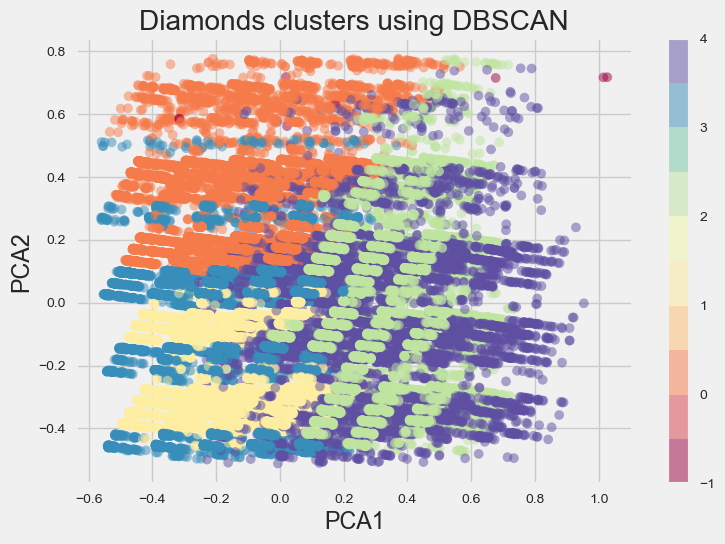

In [46]:
#Use scatterplot to show clusters via PCA
plt.scatter(df2[:, 0], df2[:, 1],
            c= db_labels.astype(float), edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Diamonds clusters using DBSCAN') 
plt.colorbar();

In [47]:
df1["clusterDBSCAN"] = db_labels.astype(float)

In [48]:
df1

,price,carat,size,depth,table,color,clarity,cut,cluster,clusterDBSCAN
0,0.000000,0.006237,0.009947,0.513889,0.230769,0.166667,0.428571,0.50,1.0,0.0
1,0.000000,0.002079,0.008985,0.466667,0.346154,0.166667,0.285714,0.75,4.0,1.0
2,0.000054,0.006237,0.009914,0.386111,0.423077,0.166667,0.571429,0.25,1.0,0.0
3,0.000433,0.018711,0.012166,0.538889,0.288462,0.833333,0.714286,0.75,3.0,2.0
4,0.000487,0.022869,0.013518,0.563889,0.288462,1.000000,0.428571,0.25,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...
53938,0.131427,0.137214,0.036652,0.500000,0.288462,0.666667,0.428571,0.75,3.0,2.0
53939,0.131427,0.114345,0.032435,0.533333,0.230769,0.000000,0.428571,0.50,1.0,0.0
53940,0.131373,0.106029,0.030201,0.486111,0.230769,0.166667,0.285714,0.75,4.0,1.0
53941,0.131373,0.106029,0.029374,0.466667,0.365385,0.333333,0.285714,0.75,4.0,1.0


We put in the dataset which cluster each diamond was going to belong to, so that the data can be analyzed dividing them into clusters and then we can see the characteristics of each group

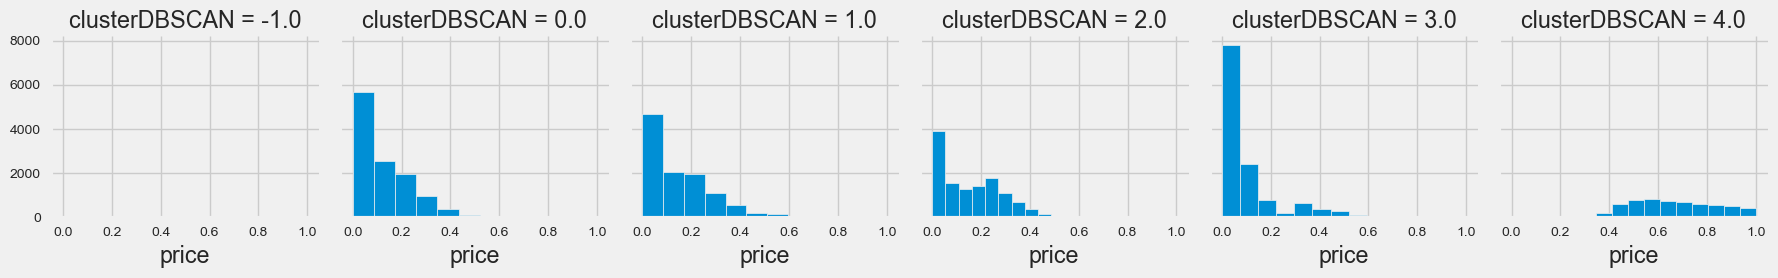

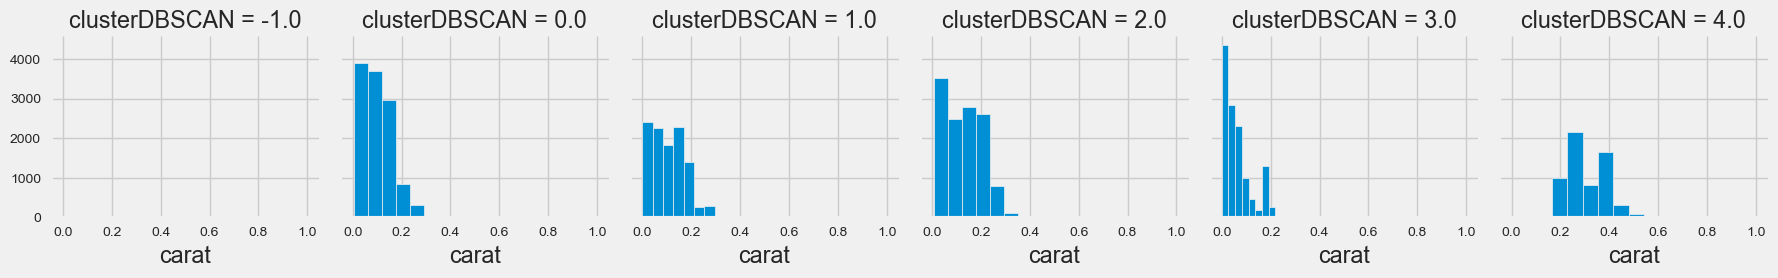

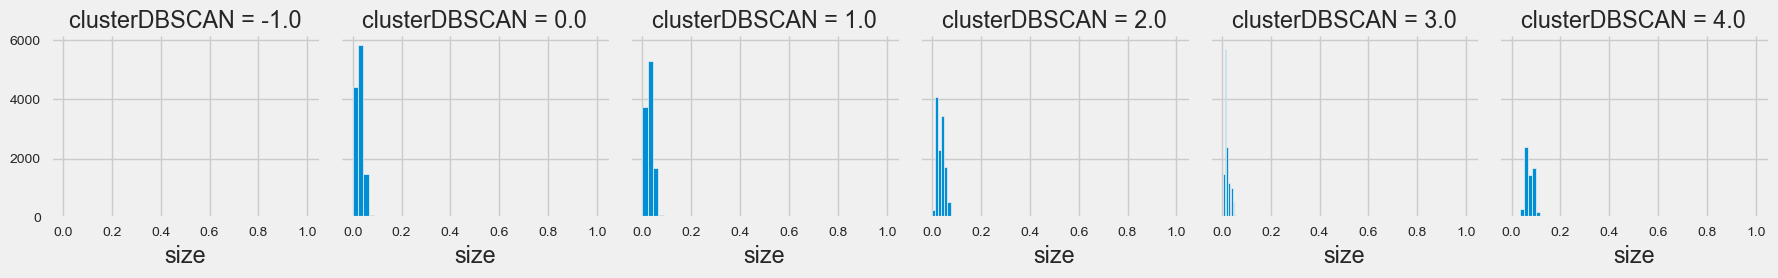

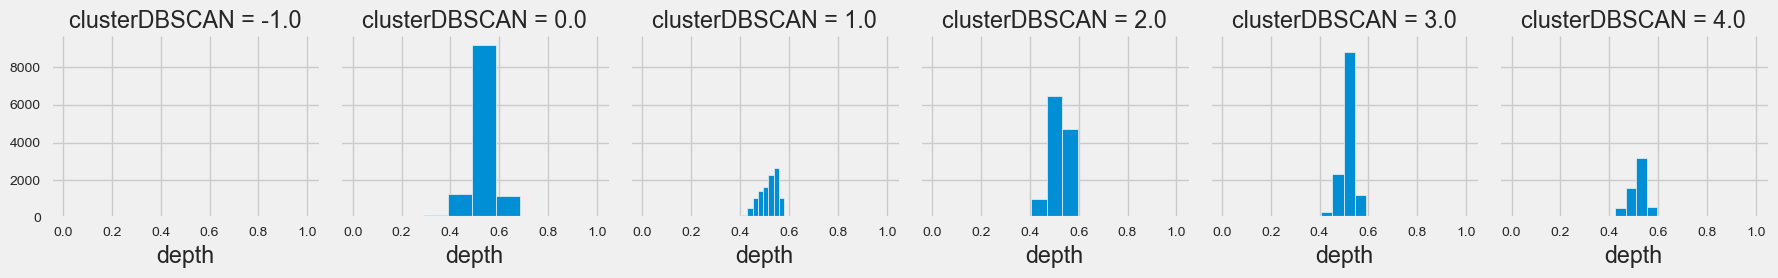

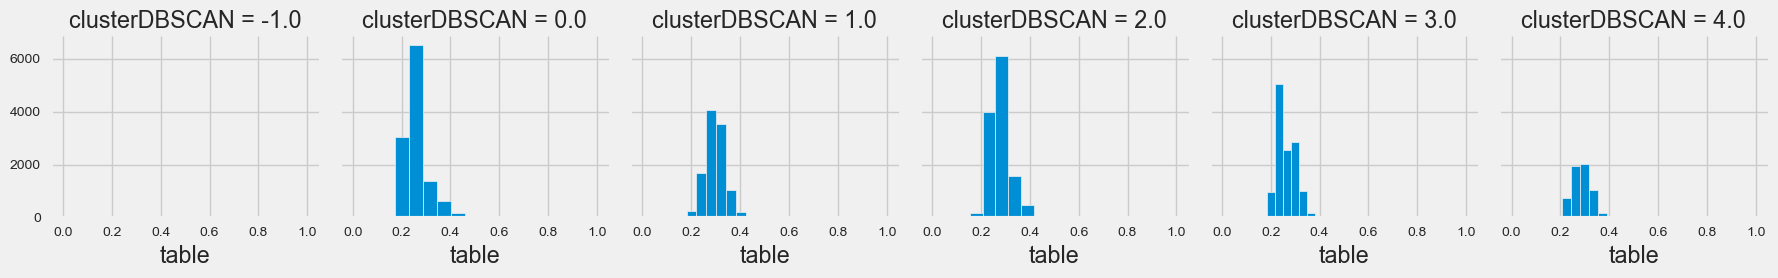

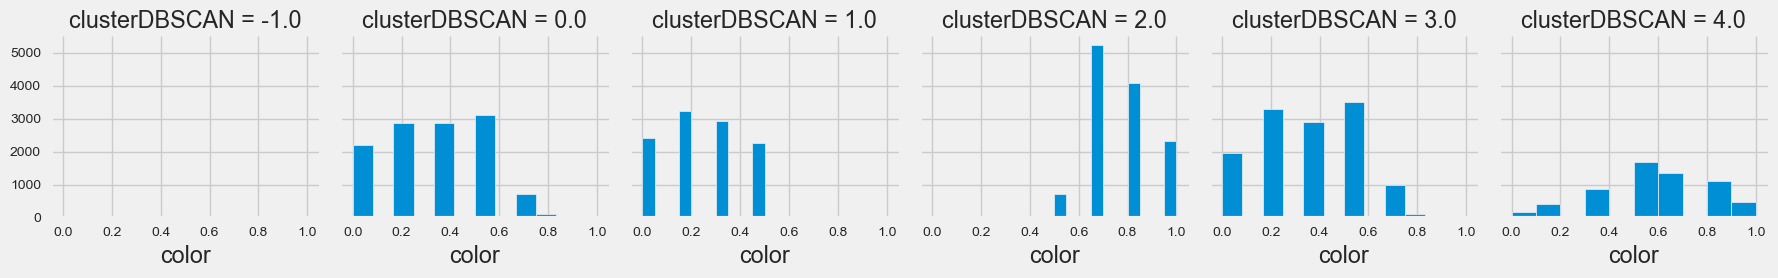

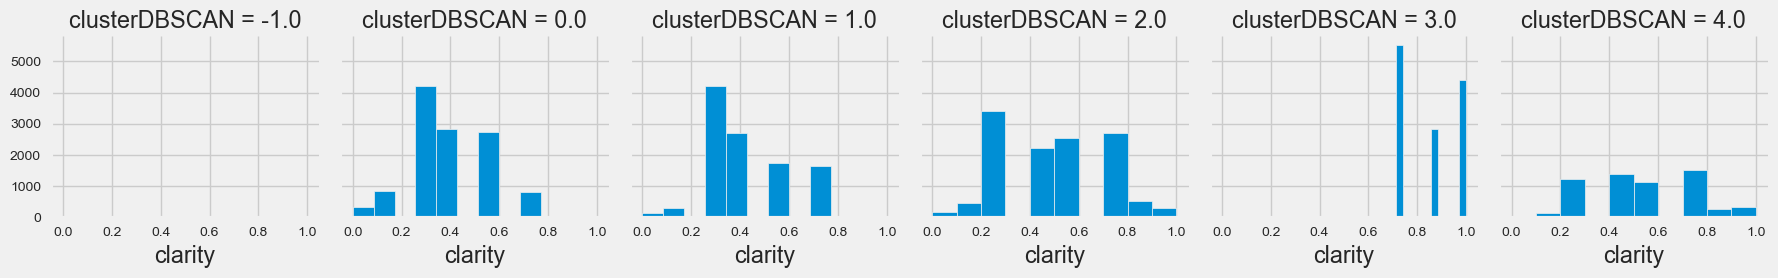

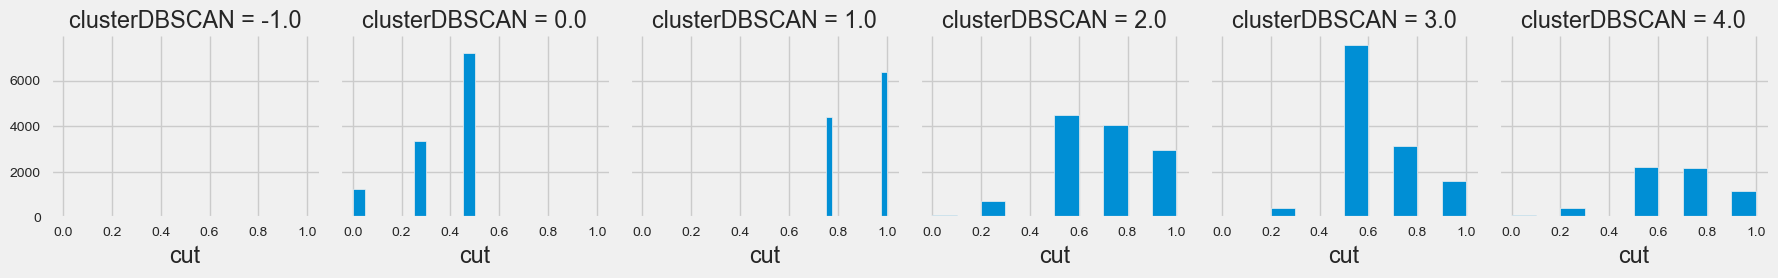

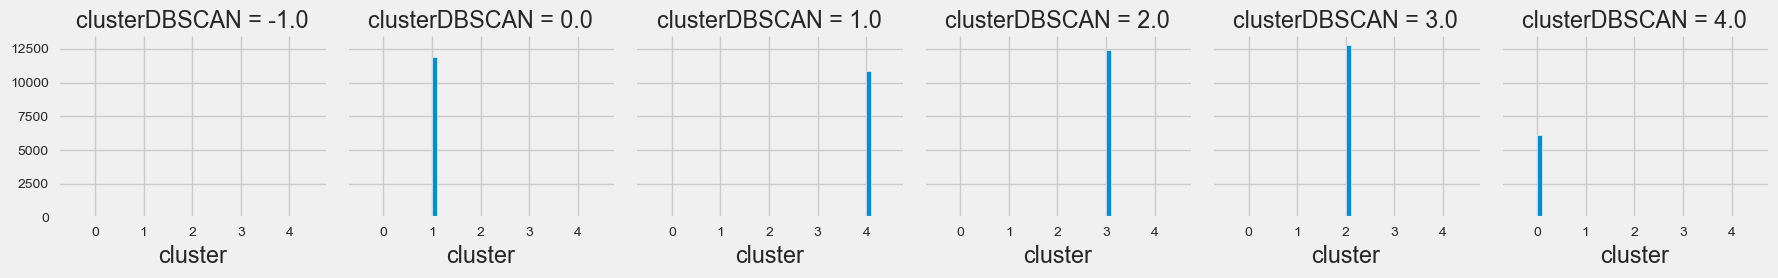

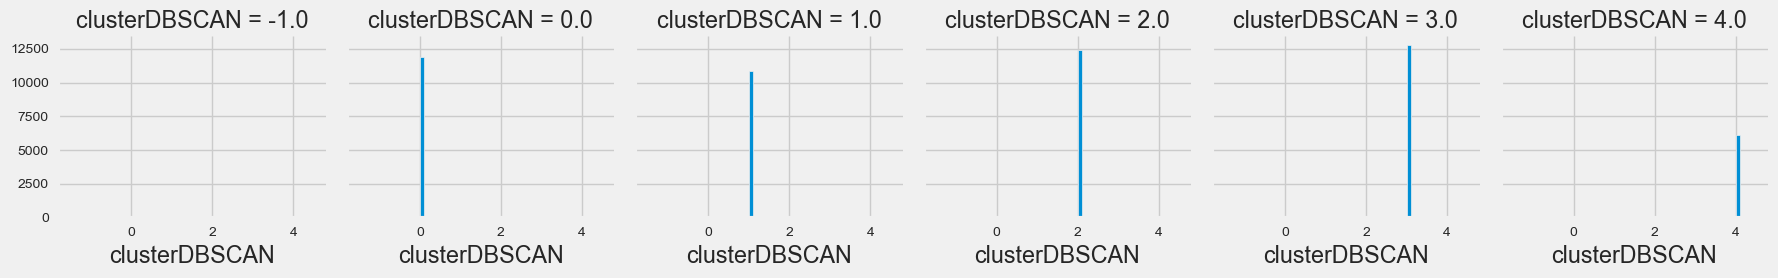

In [49]:
for c in df1:
    grid= sns.FacetGrid(df1, col='clusterDBSCAN')
    grid.map(plt.hist, c)    

In [50]:
# Number of clusters in labels, ignoring noise if present.
db_labels = db.labels_
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 10


# Validate with test data

In [51]:
db = DBSCAN(eps=0.4, min_samples=7)
db.fit_predict(df1)

array([0, 1, 0, ..., 1, 1, 1])

In [52]:
y_pred1 = db.fit_predict(df1)

In [53]:
#preds = db.labels_
data = pd.DataFrame(df)
data['clusterDBSCAN'] = y_pred1
data.head(10)

,price,carat,size,depth,table,color,clarity,cut,cluster,clusterDBSCAN
0,326,0.23,38.202030,61.5,55.0,1,3,2,4,0
1,326,0.21,34.505856,59.8,61.0,1,2,3,3,1
2,327,0.23,38.076885,56.9,65.0,1,4,1,4,0
3,334,0.29,46.724580,62.4,58.0,5,5,3,0,2
4,335,0.31,51.917250,63.3,58.0,6,3,1,0,2
5,336,0.24,38.693952,62.8,57.0,6,7,4,0,2
6,336,0.24,38.830870,62.3,57.0,5,6,4,0,2
7,337,0.26,42.321081,61.9,55.0,4,2,4,0,2
8,337,0.22,36.425214,65.1,61.0,1,5,0,4,0
9,338,0.23,38.718000,59.4,61.0,4,4,4,0,2


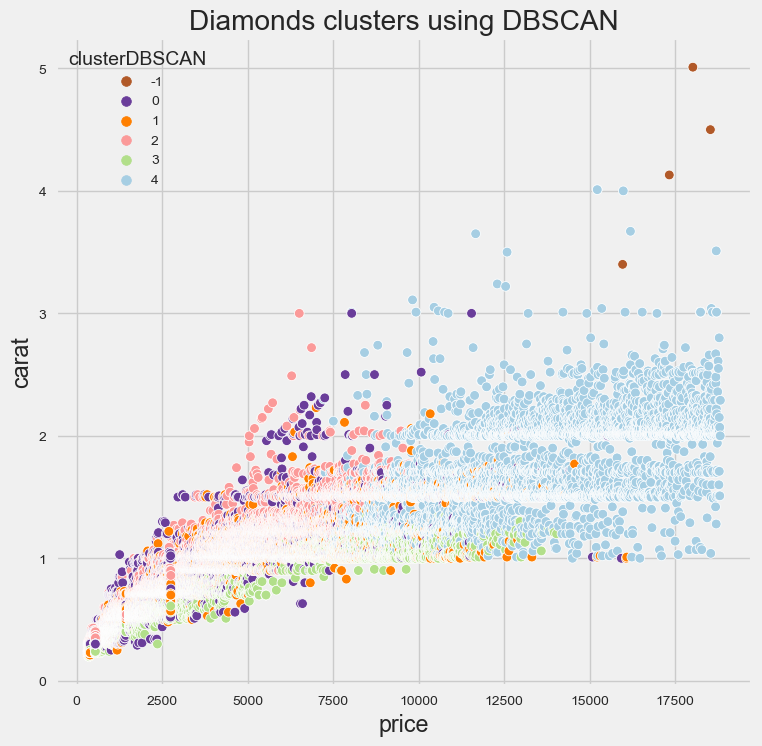

In [54]:
#Use scatterplot to show clusters via DBSCAN
plt.figure(figsize=(8,8))
sns.scatterplot(x='price',y='carat',hue="clusterDBSCAN",data=data,palette='Paired_r')
plt.title('Diamonds clusters using DBSCAN')
plt.show()

In [55]:
dff = df1.groupby("cluster")

In [56]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [57]:
#View the statistical summary of clusters
dff.describe(include="all")

price                                                              \
           count      mean       std       min       25%       50%       75%   
cluster                                                                        
0.0       6097.0  0.671362  0.166232  0.345678  0.534357  0.658053  0.806239   
1.0      11859.0  0.129782  0.117015  0.000000  0.033924  0.094772  0.200546   
2.0      12776.0  0.104280  0.129324  0.001514  0.025734  0.043169  0.119763   
3.0      12381.0  0.155758  0.123609  0.000433  0.034438  0.134670  0.250473   
4.0      10830.0  0.150069  0.134349  0.000000  0.035749  0.114424  0.229753   

                     carat                                                    \
              max    count      mean       std       min       25%       50%   
cluster                                                                        
0.0      1.000000   6097.0  0.311245  0.078212  0.166320  0.270270  0.288981   
1.0      0.868249  11859.0  0.101712  0.068558  0.004158  0.041580  0.091476   
2.0      0.741039  12776.0  0.064931  0.052926  0.000000  0.024948  0.043659   
3.0      0.541926  12381.0  0.128790  0.079693  0.006237  0.045738  0.126819   
4.0      0.852084  10830.0  0.108747  0.067515  0.000000  0.043659  0.103950   

                                size                                     \
              75%       max    count      mean       std  min       25%   
cluster                                                                   
0.0      0.376299  1.000000   6097.0  0.071767  0.019853  0.0  0.062538   
1.0      0.166320  0.582121  11859.0  0.029127  0.013750  0.0  0.017196   
2.0      0.083160  0.274428  12776.0  0.021874  0.010780  0.0  0.013622   
3.0      0.189189  0.582121  12381.0  0.034709  0.016123  0.0  0.018170   
4.0      0.168399  0.422037  10830.0  0.030619  0.013780  0.0  0.017651   

                                         depth                                \
              50%       75%       max    count      mean       std       min   
cluster                                                                        
0.0      0.067741  0.084678  1.000000   6097.0  0.517664  0.038748  0.338889   
1.0      0.027533  0.039923  0.218326  11859.0  0.531812  0.052978  0.000000   
2.0      0.017513  0.025889  0.064234  12776.0  0.516574  0.028541  0.222222   
3.0      0.034278  0.047169  0.126189  12381.0  0.520714  0.035090  0.000000   
4.0      0.029905  0.042093  0.218326  10830.0  0.515664  0.037626  0.386111   

                                                   table                      \
              25%       50%       75%       max    count      mean       std   
cluster                                                                        
0.0      0.497222  0.522222  0.541667  0.766667   6097.0  0.285229  0.041944   
1.0      0.508333  0.527778  0.561111  1.000000  11859.0  0.269534  0.049328   
2.0      0.502778  0.519444  0.533333  0.683333  12776.0  0.267300  0.037471   
3.0      0.502778  0.525000  0.541667  0.850000  12381.0  0.279722  0.041741   
4.0      0.488889  0.522222  0.547222  0.602778  10830.0  0.293975  0.037334   

                                                             color            \
              min       25%       50%       75%       max    count      mean   
cluster                                                                        
0.0      0.134615  0.250000  0.288462  0.307692  1.000000   6097.0  0.576240   
1.0      0.115385  0.230769  0.250000  0.288462  0.692308  11859.0  0.299238   
2.0      0.153846  0.250000  0.269231  0.288462  0.480769  12776.0  0.315344   
3.0      0.000000  0.250000  0.269231  0.307692  0.519231  12381.0  0.774762   
4.0      0.019231  0.269231  0.288462  0.326923  0.423077  10830.0  0.243706   

                                                                clarity  \
              std  min       25%       50%       75%       max    count   
cluster                                                

# 8. KNN Model

The k-nearest neighbors algorithm, also known as KNN or k-NN, is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point. 

KNN Pros:

 1) K-NN is pretty intuitive and simple

 2) K-NN has no assumptions

 3) No Training Step

 4) Very easy to implement for multi-class problem

 5) Can be used both for Classification and Regression

Cons: 

 1) K-NN slow algorithm

 2) Optimal number of neighbors

 3) Outlier sensitivity

 4) Imbalanced data causes problems


In [58]:
#Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [59]:
#Build a new classifier 
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

In [60]:
knn_cm = confusion_matrix(y_test, y_pred)
knn_acc = metrics.accuracy_score(y_test, y_pred)
print(knn_cm)
print(knn_acc)

[[ 239   77    1    5    6]
 [  29  499   36  130  306]
 [   4   14 3921  209  168]
 [   0   73  389 1915  357]
 [   6  271  728  853  553]]
0.6605802205950505


# KNN Tunning

In [61]:
# Define the hyperparameter grid to search over
knn_params = {'n_neighbors': range(1, 31)}

# Perform grid search cross-validation to find the best hyperparameters
grid_knn = GridSearchCV(knn, knn_params, cv=5)
grid_knn.fit(X_train_scaled, y_train)
knn_best = grid_knn.best_estimator_

# Print the best hyperparameters and score found during the grid search
print("Best parameters:", knn_best)
print("Best score:", grid_knn.best_score_)

Best parameters: KNeighborsClassifier(n_neighbors=28)
Best score: 0.6890902568592854


# Make Prediction After Tunning

In [62]:
#Model building using KNN
knn = KNeighborsClassifier(n_neighbors=28)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

In [63]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)

[[ 206  110    2    5    5]
 [  14  438   49  175  324]
 [   3    5 4025  200   83]
 [   0   10  376 2158  190]
 [   1  126  729  958  597]]
              precision    recall  f1-score   support

           0       0.92      0.63      0.75       328
           1       0.64      0.44      0.52      1000
           2       0.78      0.93      0.85      4316
           3       0.62      0.79      0.69      2734
           4       0.50      0.25      0.33      2411

    accuracy                           0.69     10789
   macro avg       0.69      0.61      0.63     10789
weighted avg       0.67      0.69      0.66     10789

0.6881082584113449
MSE    : 0.94 
MAE    : 0.49 
RMSE   : 0.97 
R2     : 0.12 


After tunning, accuracy score is 0.688, slightly higher than 0.661 (before KNN tunning).

# Principal Component Analysis (PCA)


In [64]:
df3 = pd.DataFrame(X_test_scaled)

In [65]:
#Build PCA
pca = PCA(n_components = 2)
pca.fit(df3)
df4 = pca.transform(df3)

In [66]:
pca_data = pd.DataFrame(df4, columns=["PCA1","PCA2"])
pca_data['cut'] = y_train

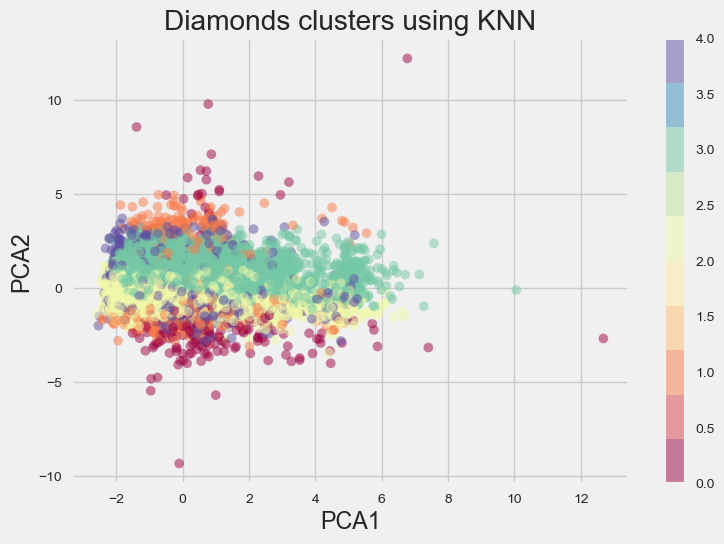

In [67]:
#Use scatterplot to show clusters via PCA
plt.scatter(pca_data["PCA1"], pca_data["PCA2"],
            c= y_pred, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Diamonds clusters using KNN') 
plt.colorbar();

# Classification After PCA

In [68]:
pca_data.head()

,PCA1,PCA2,cut
0,-2.003864,-0.420700,2.0
1,1.221955,-1.576272,3.0
2,-0.433344,3.240174,1.0
3,-1.405037,-0.683748,3.0
4,1.947148,-1.024147,NaN


In [69]:
pca_data['cut'].value_counts()

2.0    2650
3.0    2208
4.0    2169
1.0    1116
0.0     430
Name: cut, dtype: int64

# KNN Model via PCA Features

In [70]:
knn_pca = KNeighborsClassifier(n_neighbors=28)
knn_pca.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

In [71]:
print(confusion_matrix(y_test, y_pred_knn))
print(metrics.accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))
mse = mean_squared_error(y_test, y_pred_knn)
mae = mean_absolute_error(y_test, y_pred_knn)
rmse = mean_squared_error(y_test, y_pred_knn)**0.5
r2 = r2_score(y_test, y_pred_knn)

print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)

[[ 206  110    2    5    5]
 [  14  438   49  175  324]
 [   3    5 4025  200   83]
 [   0   10  376 2158  190]
 [   1  126  729  958  597]]
0.6881082584113449
              precision    recall  f1-score   support

           0       0.92      0.63      0.75       328
           1       0.64      0.44      0.52      1000
           2       0.78      0.93      0.85      4316
           3       0.62      0.79      0.69      2734
           4       0.50      0.25      0.33      2411

    accuracy                           0.69     10789
   macro avg       0.69      0.61      0.63     10789
weighted avg       0.67      0.69      0.66     10789

MSE    : 0.94 
MAE    : 0.49 
RMSE   : 0.97 
R2     : 0.12 


# Validate with test data

In [72]:
data1 = pd.DataFrame(X_test)
data1['cut'] = y_pred
data1.head()

,price,carat,size,depth,table,color,clarity,cut
1388,559,0.24,39.223600,62.1,56.0,3,6,2
19841,8403,1.21,197.905488,62.9,54.0,2,5,2
41647,1238,0.50,79.880424,61.7,68.0,1,2,1
41741,1243,0.50,80.682206,62.8,56.0,0,3,2
17244,6901,1.55,252.779208,62.3,55.0,1,3,2


We put in the dataset which cluster each diamond was going to belong to, so that the data can be analyzed dividing them into clusters and then we can see the characteristics of each group

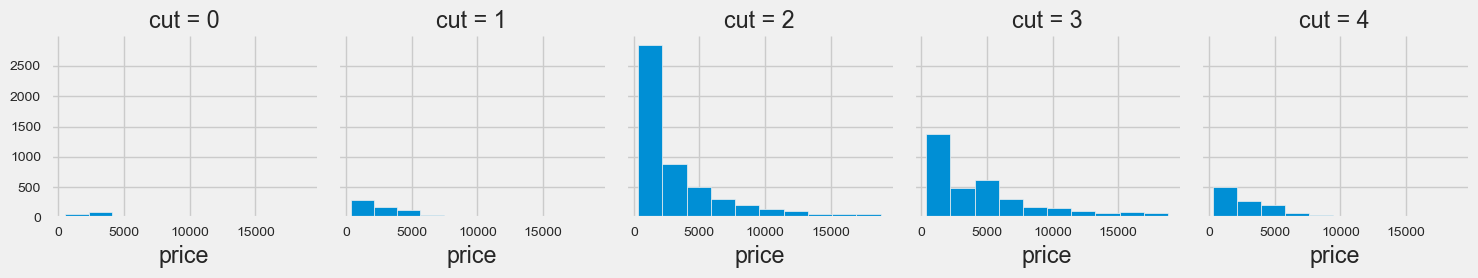

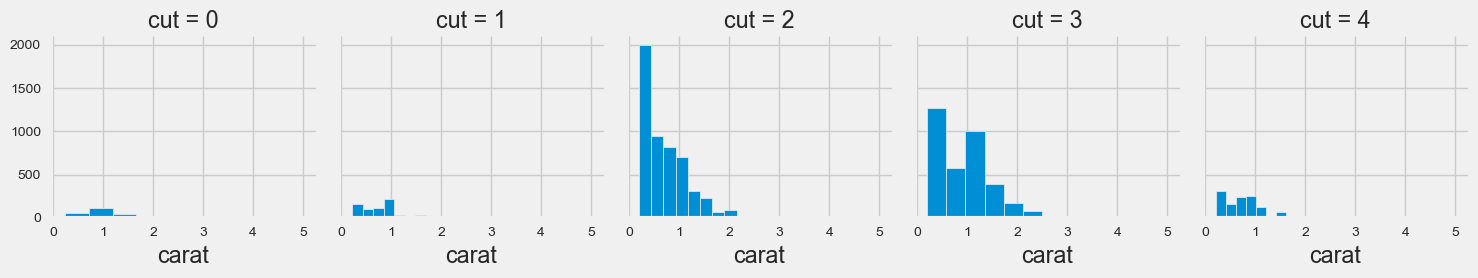

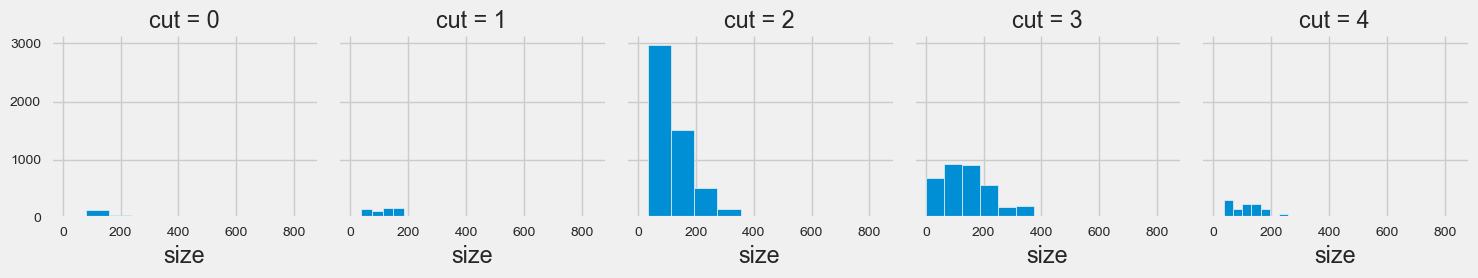

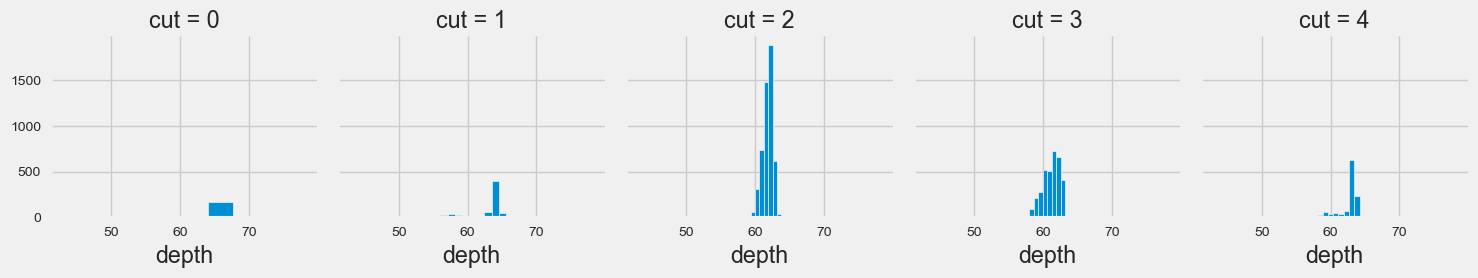

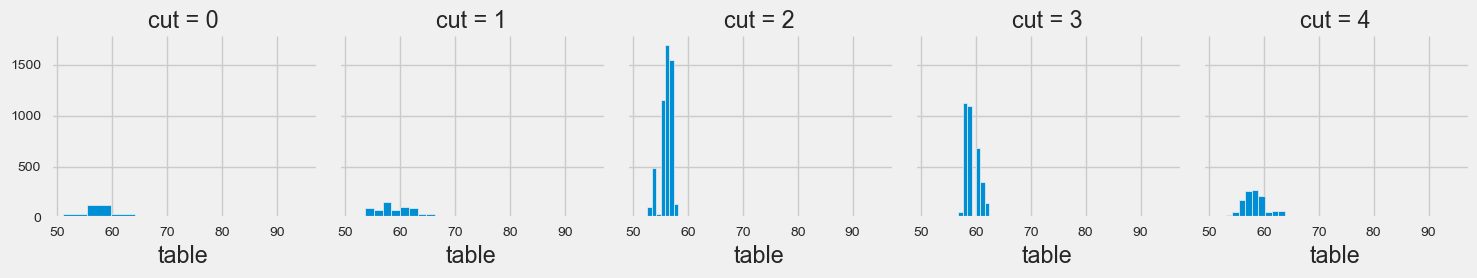

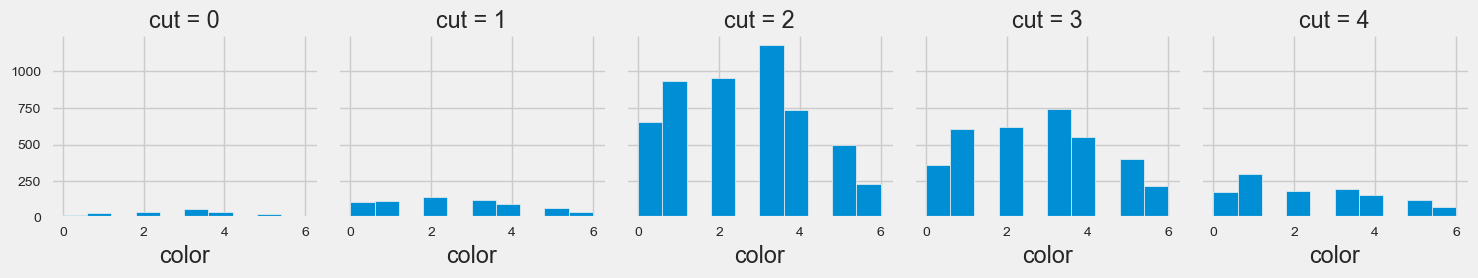

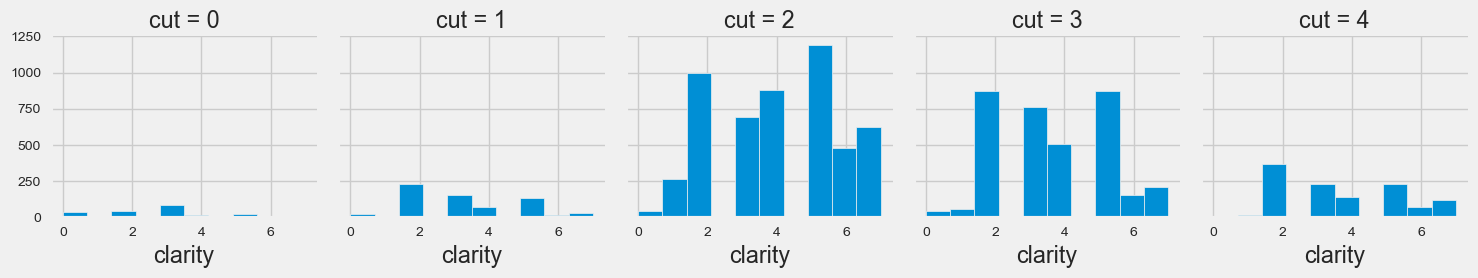

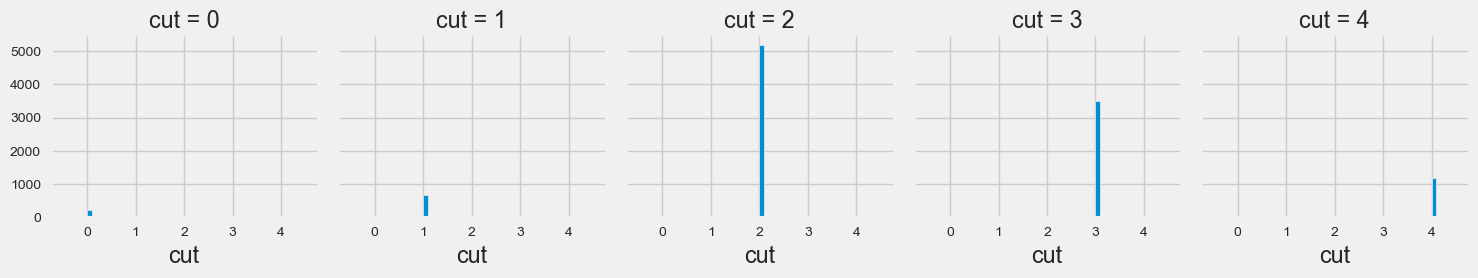

In [73]:
data1.describe()
for c in data1:
    grid= sns.FacetGrid(data1, col='cut')
    grid.map(plt.hist, c) 

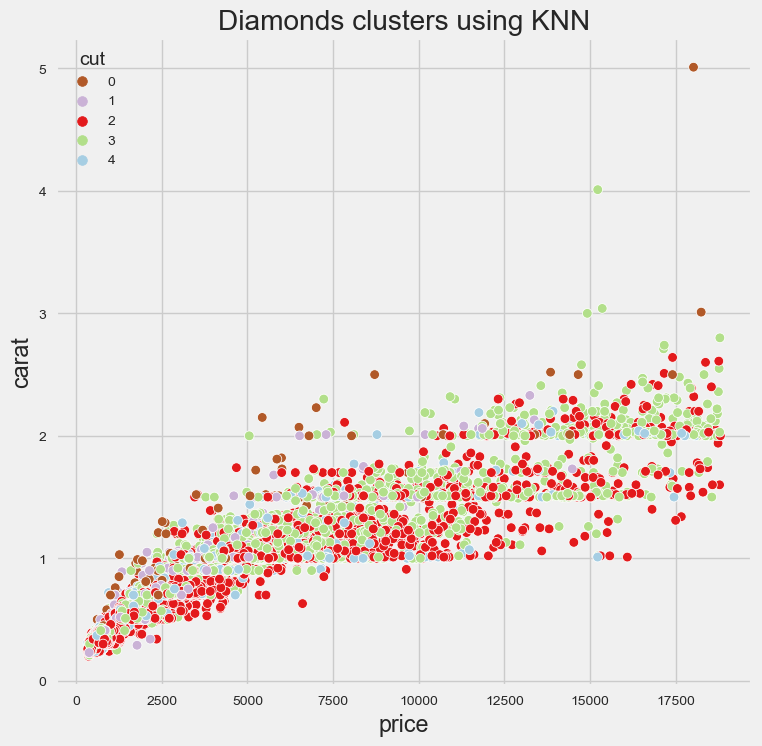

In [74]:
#Use scatterplot to show clusters via KNN
plt.figure(figsize=(8,8))
sns.scatterplot(x='price',y='carat',hue="cut", data=data1,palette='Paired_r')
plt.title('Diamonds clusters using KNN')
plt.show()

# Conclusion: 

In Data Science and Machine Learning, k-means clustering and dbscan clustering both are a form of unsupervised learning, which means that they do not require training data. k-NN clustering, on the other hand, is a form of supervised learning, which means that it does require training data. k-means clustering is also a much faster algorithm than DBScan clustering & k-NN clustering.

Dataset Reference:

https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices?select=Diamonds+Prices2022.csv
    